# Neural Machine Translation

Transformers provides thousands of pretrained models to perform tasks on different modalities such as text, vision, and audio. SentencePiece python wrapper offers the encoding, decoding and training of SentencePiece. Datasets library allows us to load datasets and do efficient pre-processing on them.

In [ ]:
!pip install transformers sentencepiece datasets

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 1.2 MB 41.7 MB/s 
     |████████████████████████████████| 325 kB 47.9 MB/s 
     |████████████████████████████████| 596 kB 39.6 MB/s 
     |████████████████████████████████| 880 kB 44.4 MB/s 
     |████████████████████████████████| 6.6 MB 29.6 MB/s 
     |████████████████████████████████| 77 kB 6.5 MB/s 
     |████████████████████████████████| 136 kB 37.2 MB/s 
     |████████████████████████████████| 212 kB 46.3 MB/s 
     |████████████████████████████████| 1.1 MB 41.1 MB/s 
     |████████████████████████████████| 127 kB 47.1 MB/s 
     |████████████████████████████████| 271 kB 50.7 MB/s 
     |████████████████████████████████| 144 kB 46.2 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=16e8eb85d176b88a917ce7e434930411e3996363c816fe152df4ffcea591973c
  Stored in directory: /root/.cac

In [ ]:
from datasets import load_dataset
from google.colab import drive
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook
from google.colab import drive
drive.mount('/content/gdrive')

sns.set()

/usr/local/lib/python3.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Mounted at /content/gdrive


mT5 is pretrained on the mC4 corpus, covering 101 languages.<br>

In [ ]:
model_repo = 'google/mt5-small'
model_path = '/content/gdrive/My Drive/mt5_translation.pt'
max_seq_len = 20

Loading a pre-trained tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)

Downloading:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/553 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Loading a pre-trained model

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
model = model.cuda()

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
input_sent = 'Here is our test sentence'
token_ids = tokenizer.encode(input_sent, return_tensors='pt')
token_ids

tensor([[10421,   339,  1406,  2978,   259, 98923,     1]])

In [ ]:
model_out = model.generate(token_ids)
print(model_out)

RuntimeError: ignored

In [ ]:
'''output_text = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)'''

'output_text = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(model_out[0]))\nprint(output_text)'

Test Tokenizer

In [ ]:
example_input_str = '<jp> This is just a test nbuig.'
input_ids = tokenizer.encode(example_input_str, return_tensors='pt')
print("Input IDs: ",input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print("Tokens: ",tokens)

Input IDs:  tensor([[1042, 3889,  669, 1494,  339, 1627,  259,  262, 2978,  259,  272, 1982,
         1315,  260,    1]])
Tokens:  ['▁<', 'jp', '>', '▁This', '▁is', '▁just', '▁', 'a', '▁test', '▁', 'n', 'bu', 'ig', '.', '</s>']


Prepare Dataset

In [ ]:
dataset = load_dataset('alt')

No config specified, defaulting to: alt/alt-parallel


Generating train split:   0%|          | 0/18094 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1004 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1019 [00:00<?, ? examples/s]

Dataset alt downloaded and prepared to /root/.cache/huggingface/datasets/alt/alt-parallel/1.0.0/e784a3f2a9f6bdf277940de6cc9d700eab852896cd94aad4233caf26008da9ed. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [ ]:
train_dataset.shape

(18094, 4)

In [ ]:
test_dataset.shape

(1019, 4)

In [ ]:
train_dataset[0]

{'SNT.URLID': '80188',
 'SNT.URLID.SNTID': '1',
 'translation': {'bg': 'ফ্রান্সের প্যারিসের পার্ক দি প্রিন্সেস-এ হওয়া ২০০৭-এর রাগবি বিশ্বকাপের পুল সি-তে ইটালি পর্তুগালকে ৩১-৫ গোলে হারিয়েছে।',
  'en': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.',
  'en_tok': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes , Paris , France .',
  'fil': 'Natalo ng Italya ang Portugal sa puntos na 31-5 sa Grupong C noong 2007 sa Pandaigdigang laro ng Ragbi sa Parc des Princes, Paris, France.',
  'hi': '2007 में फ़्रांस, पेरिस के पार्क डेस प्रिंसेस में हुए रग्बी विश्व कप के पूल C में इटली ने पुर्तगाल को 31-5 से हराया।',
  'id': 'Italia berhasil mengalahkan Portugal 31-5 di grup C dalam Piala Dunia Rugby 2007 di Parc des Princes, Paris, Perancis.',
  'ja': 'フランスのパリ、パルク・デ・プランスで行われた2007年ラグビーワールドカップのプールCで、イタリアは31対5でポルトガルを下した。',
  'khm': 'អ៊ីតាលីបានឈ្នះលើព័រទុយហ្គាល់ 31-5 ក្នុងប៉ូលCនៃពីធីប្រកួតពានរង្វាន់

In [ ]:
token_mapping = {'en':'<en>','ja':'<jp>','zh':'<zh>','hi':'<hi>'}

In [ ]:
special_tokens_dict = {'additional_special_tokens': list(token_mapping.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(250104, 512)

In [ ]:
token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt', padding='max_length',
    truncation=True, max_length=max_seq_len)
print(token_ids)

tensor([[250101,   1494,    339,   1627,    259,    262,   2978,    259,    272,
           1982,   1315,    260,      1,      0,      0,      0,      0,      0,
              0,      0]])


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print(tokens)

['<jp>', '▁This', '▁is', '▁just', '▁', 'a', '▁test', '▁', 'n', 'bu', 'ig', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [ ]:
def encode_input_str(text,target_lang,tokenizer,seq_len,token_map=token_mapping):
  target_lang_token = token_mapping[target_lang]

  input_ids = tokenizer.encode(text=target_lang_token+text,return_tensors='pt',padding='max_length',truncation=True,max_length=seq_len)

  return input_ids[0]


def encode_target_str(text,tokenizer,seq_len,token_map=token_mapping):
  token_ids = tokenizer.encode(text=text,return_tensors='pt',padding='max_length',truncation=True,max_length=seq_len)

  return token_ids[0]

def format_translation_data(translations,token_mapping,tokenizer,seq_len=128):

  langs = list(token_mapping.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if(input_text is None or target_text is None):
    return None

  input_token_ids = encode_input_str(input_text,target_lang,tokenizer,seq_len,token_mapping)

  target_token_ids = encode_target_str(target_text,tokenizer,seq_len,token_mapping)

  return input_token_ids, target_token_ids


def transform_batch(batch,token_mapping,tokenizer):
  inputs = []
  targets = []

  for translation_set in batch['translation']:
    formatted_data = format_translation_data(translation_set,token_mapping,tokenizer,max_seq_len)

    if(formatted_data is None):
      continue

    input_ids, target_ids = formatted_data

    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))

  batch_input_ids = torch.cat(inputs).cuda()

  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids


def get_data_generator(dataset,token_mapping,tokenizer,batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0,len(dataset),batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch,token_mapping,tokenizer)




In [ ]:
in_ids, out_ids = format_translation_data(train_dataset[0]['translation'],token_mapping,tokenizer)

print(''.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(''.join(tokenizer.convert_ids_to_tokens(out_ids)))

data_gen = get_data_generator(train_dataset, token_mapping, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

<hi>▁フランスのパリ、パルク・デ・プランスで行われた2007年ラグビーワールドカップのプールCで、イタリアは31対5でポルトガルを下した。</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
▁2007▁में▁फ़्रांस,▁पेरिस▁के▁पार्क▁डेस▁प्रिंसेस▁में▁हुए▁रग्बी▁विश्व▁कप▁के▁पूल▁C▁में▁इटली▁ने▁पुर्तगाल▁को▁31-5▁से▁हराया।</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [ ]:
data_batch[0]

tensor([[250101,    259,  62016,   3594,  52812,  37504, 175021,  10484,   4103,
           3582,  63192,   3913, 152827,  11755,   4874, 181439,    306,      1,
              0,      0],
        [250101,    259,  53793,   1223, 119524,   8349, 213981,   2230,   7684,
          16964,  47685,    261,  27611, 198135,  38722,  45609,  14456,   1107,
         101700,      1],
        [250100,  12010,   1665,  37966,  45475,   1053,   9031,  17467,    641,
            259,   2390, 118076,  22687,   1712,    975,   5725,   1712,   2375,
           1693,      1],
        [250103,    259,  89765,  62784,  57947,  58115, 117541,   2640,    493,
           7031,  30504,   9734,  31985,   1107,   2518,  11688,   5991, 164808,
           2640,      1],
        [250100,    259, 122434,    261,   2037,  25542,    848,   1087,    891,
           2427,    838,   4093, 239443, 183744,  23616,  85032,  48084,  18581,
           3480,      1],
        [250100,    259, 100393, 153909,    600,  63979,    

In [ ]:
train_dataset[0]

{'SNT.URLID': '80188',
 'SNT.URLID.SNTID': '1',
 'translation': {'bg': 'ফ্রান্সের প্যারিসের পার্ক দি প্রিন্সেস-এ হওয়া ২০০৭-এর রাগবি বিশ্বকাপের পুল সি-তে ইটালি পর্তুগালকে ৩১-৫ গোলে হারিয়েছে।',
  'en': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.',
  'en_tok': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes , Paris , France .',
  'fil': 'Natalo ng Italya ang Portugal sa puntos na 31-5 sa Grupong C noong 2007 sa Pandaigdigang laro ng Ragbi sa Parc des Princes, Paris, France.',
  'hi': '2007 में फ़्रांस, पेरिस के पार्क डेस प्रिंसेस में हुए रग्बी विश्व कप के पूल C में इटली ने पुर्तगाल को 31-5 से हराया।',
  'id': 'Italia berhasil mengalahkan Portugal 31-5 di grup C dalam Piala Dunia Rugby 2007 di Parc des Princes, Paris, Perancis.',
  'ja': 'フランスのパリ、パルク・デ・プランスで行われた2007年ラグビーワールドカップのプールCで、イタリアは31対5でポルトガルを下した。',
  'khm': 'អ៊ីតាលីបានឈ្នះលើព័រទុយហ្គាល់ 31-5 ក្នុងប៉ូលCនៃពីធីប្រកួតពានរង្វាន់

In [ ]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

**Model Training**<br>
We will be training our model for 5 epochs. The training dataset will be passed onto the model in batches of 16. The initial learning rate will be 5e-4. We will be using the Adam optimizer which is an adaptive optimizer.

In [ ]:
n_epochs = 5
batch_size = 16
print_freq = 50
checkpoint_freq = 1000
lr = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [ ]:
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
losses = []

In [ ]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, token_mapping,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [ ]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, token_mapping,
                                      tokenizer, batch_size)
                
  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss and update weights
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))
      
    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, test_dataset)
      print('Saving model with test loss of {:.3f}'.format(test_loss))
      torch.save(model.state_dict(), model_path)

torch.save(model.state_dict(), model_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 1 | Step: 50 | Avg. loss: 2.707 | lr: 0.00044642857142857147
Epoch: 1 | Step: 100 | Avg. loss: 2.944 | lr: 0.0004960707269155207
Epoch: 1 | Step: 150 | Avg. loss: 2.954 | lr: 0.0004916056438649759
Epoch: 1 | Step: 200 | Avg. loss: 3.007 | lr: 0.00048714056081443114
Epoch: 1 | Step: 250 | Avg. loss: 3.005 | lr: 0.0004826754777638864
Epoch: 1 | Step: 300 | Avg. loss: 3.022 | lr: 0.0004782103947133417
Epoch: 1 | Step: 350 | Avg. loss: 3.003 | lr: 0.00047374531166279694
Epoch: 1 | Step: 400 | Avg. loss: 2.941 | lr: 0.0004692802286122522
Epoch: 1 | Step: 450 | Avg. loss: 2.959 | lr: 0.0004648151455617075
Epoch: 1 | Step: 500 | Avg. loss: 2.923 | lr: 0.00046035006251116275
Epoch: 1 | Step: 550 | Avg. loss: 2.926 | lr: 0.00045588497946061796
Epoch: 1 | Step: 600 | Avg. loss: 2.937 | lr: 0.00045141989641007323
Epoch: 1 | Step: 650 | Avg. loss: 2.992 | lr: 0.0004469548133595285
Epoch: 1 | Step: 700 | Avg. loss: 2.920 | lr: 0.00044248973030898376
Epoch: 1 | Step: 750 | Avg. loss: 2.936 | 

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 2 | Step: 50 | Avg. loss: 2.743 | lr: 0.00039953563136274335
Epoch: 2 | Step: 100 | Avg. loss: 2.859 | lr: 0.0003950705483121986
Epoch: 2 | Step: 150 | Avg. loss: 2.708 | lr: 0.00039060546526165383
Epoch: 2 | Step: 200 | Avg. loss: 2.730 | lr: 0.00038614038221110916
Epoch: 2 | Step: 250 | Avg. loss: 2.727 | lr: 0.00038167529916056437
Epoch: 2 | Step: 300 | Avg. loss: 2.734 | lr: 0.00037721021611001964
Epoch: 2 | Step: 350 | Avg. loss: 2.706 | lr: 0.00037274513305947496
Epoch: 2 | Step: 400 | Avg. loss: 2.728 | lr: 0.0003682800500089302
Epoch: 2 | Step: 450 | Avg. loss: 2.759 | lr: 0.00036381496695838544
Epoch: 2 | Step: 500 | Avg. loss: 2.666 | lr: 0.00035934988390784066
Epoch: 2 | Step: 550 | Avg. loss: 2.718 | lr: 0.000354884800857296
Epoch: 2 | Step: 600 | Avg. loss: 2.643 | lr: 0.0003504197178067512
Epoch: 2 | Step: 650 | Avg. loss: 2.714 | lr: 0.00034595463475620646
Epoch: 2 | Step: 700 | Avg. loss: 2.737 | lr: 0.00034148955170566173
Epoch: 2 | Step: 750 | Avg. loss: 2.690 

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 3 | Step: 50 | Avg. loss: 2.545 | lr: 0.0002985354527594213
Epoch: 3 | Step: 100 | Avg. loss: 2.524 | lr: 0.0002940703697088766
Epoch: 3 | Step: 150 | Avg. loss: 2.518 | lr: 0.00028960528665833185
Epoch: 3 | Step: 200 | Avg. loss: 2.564 | lr: 0.00028514020360778707
Epoch: 3 | Step: 250 | Avg. loss: 2.568 | lr: 0.0002806751205572424
Epoch: 3 | Step: 300 | Avg. loss: 2.560 | lr: 0.00027621003750669766
Epoch: 3 | Step: 350 | Avg. loss: 2.535 | lr: 0.00027174495445615287
Epoch: 3 | Step: 400 | Avg. loss: 2.576 | lr: 0.00026727987140560814
Epoch: 3 | Step: 450 | Avg. loss: 2.553 | lr: 0.0002628147883550634
Epoch: 3 | Step: 500 | Avg. loss: 2.512 | lr: 0.0002583497053045187
Epoch: 3 | Step: 550 | Avg. loss: 2.581 | lr: 0.0002538846222539739
Epoch: 3 | Step: 600 | Avg. loss: 2.539 | lr: 0.0002494195392034292
Epoch: 3 | Step: 650 | Avg. loss: 2.502 | lr: 0.0002449544561528844
Epoch: 3 | Step: 700 | Avg. loss: 2.491 | lr: 0.0002404893731023397
Epoch: 3 | Step: 750 | Avg. loss: 2.470 | lr

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 4 | Step: 50 | Avg. loss: 2.407 | lr: 0.0001975352741560993
Epoch: 4 | Step: 100 | Avg. loss: 2.426 | lr: 0.00019307019110555458
Epoch: 4 | Step: 150 | Avg. loss: 2.446 | lr: 0.00018860510805500982
Epoch: 4 | Step: 200 | Avg. loss: 2.423 | lr: 0.0001841400250044651
Epoch: 4 | Step: 250 | Avg. loss: 2.393 | lr: 0.00017967494195392033
Epoch: 4 | Step: 300 | Avg. loss: 2.356 | lr: 0.0001752098589033756
Epoch: 4 | Step: 350 | Avg. loss: 2.355 | lr: 0.00017074477585283086
Epoch: 4 | Step: 400 | Avg. loss: 2.388 | lr: 0.00016627969280228613
Epoch: 4 | Step: 450 | Avg. loss: 2.379 | lr: 0.0001618146097517414
Epoch: 4 | Step: 500 | Avg. loss: 2.348 | lr: 0.00015734952670119664
Epoch: 4 | Step: 550 | Avg. loss: 2.401 | lr: 0.0001528844436506519
Epoch: 4 | Step: 600 | Avg. loss: 2.314 | lr: 0.00014841936060010715
Epoch: 4 | Step: 650 | Avg. loss: 2.379 | lr: 0.00014395427754956242
Epoch: 4 | Step: 700 | Avg. loss: 2.354 | lr: 0.0001394891944990177
Epoch: 4 | Step: 750 | Avg. loss: 2.340 |

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 5 | Step: 50 | Avg. loss: 2.300 | lr: 9.653509555277729e-05
Epoch: 5 | Step: 100 | Avg. loss: 2.302 | lr: 9.207001250223254e-05
Epoch: 5 | Step: 150 | Avg. loss: 2.255 | lr: 8.76049294516878e-05
Epoch: 5 | Step: 200 | Avg. loss: 2.284 | lr: 8.313984640114307e-05
Epoch: 5 | Step: 250 | Avg. loss: 2.265 | lr: 7.867476335059832e-05
Epoch: 5 | Step: 300 | Avg. loss: 2.247 | lr: 7.420968030005358e-05
Epoch: 5 | Step: 350 | Avg. loss: 2.308 | lr: 6.974459724950884e-05
Epoch: 5 | Step: 400 | Avg. loss: 2.281 | lr: 6.527951419896411e-05
Epoch: 5 | Step: 450 | Avg. loss: 2.277 | lr: 6.0814431148419366e-05
Epoch: 5 | Step: 500 | Avg. loss: 2.254 | lr: 5.634934809787462e-05
Epoch: 5 | Step: 550 | Avg. loss: 2.264 | lr: 5.188426504732988e-05
Epoch: 5 | Step: 600 | Avg. loss: 2.262 | lr: 4.7419181996785136e-05
Epoch: 5 | Step: 650 | Avg. loss: 2.237 | lr: 4.2954098946240404e-05
Epoch: 5 | Step: 700 | Avg. loss: 2.229 | lr: 3.848901589569566e-05
Epoch: 5 | Step: 750 | Avg. loss: 2.214 | lr: 3

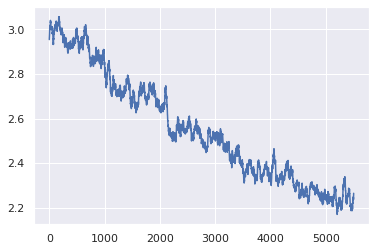

In [ ]:
window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

In [ ]:
test_sentence = test_dataset[0]['translation']['en']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'ja',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    token_map = token_mapping)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza.
Truncated input text: <jp> It has been confirmed that eight thoroughbred race horses at Randwick Racecourse</s>


In [ ]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

伝えられるところでは、クイーンズウィック競技場での8人のハイカーが、
伝えられるところでは、ラードウィック競技場での8人のハイカーが、
伝えられるところでは、ランドウィック競技場での8人のサーブ・レースの


In [ ]:
input_text = 'A computer is a digital electronic machine' #@param {type:"string"}
output_language = 'hi' #@param ["en", "ja", "zh","hi"]

input_ids = encode_input_str(
    text = input_text,
    target_lang = output_language,
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    token_map = token_mapping)
input_ids = input_ids.unsqueeze(0).cuda()

output_tokens = model.generate(input_ids, num_beams=20, length_penalty=0.2)
print(input_text + '  ->  ' + \
      tokenizer.decode(output_tokens[0], skip_special_tokens=True))

A computer is a digital electronic machine  ->  एक कंप्यूटर एक इलेक्ट्रॉनिक इलेक्ट्रिक मशीन है
